In [1]:
import gc
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from atmacup_18 import constants

import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main2/v00/v00_10_00/utils.py'>

In [2]:
RANDOM_STATE = 2024

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]
TRAFFIC_LIGHTS_BBOX_IMAGE_NAME = constants.TRAFFIC_LIGHT_BBOX_IMAGE_NAME
DEPTH_IMAGE_FILE_PREFIX = constants.DEPTH_IMAGE_FILE_PREFIX
DEPTH_IMAGE_NAMES = [
    f"{DEPTH_IMAGE_FILE_PREFIX}{image_name}.npy" for image_name in IMAGE_NAMES
]

TR_IMAGE_FEATURE_TYPE2_CSV = DATASET_DIR.joinpath("train_image_features_type2.csv")
TS_IMAGE_FEATURE_TYPE2_CSV = DATASET_DIR.joinpath("test_image_features_type2.csv")

BASE_PRED_DIR = Path("..", "..", "..", "main", "v00", "v00_15_03")
BASE_OOF_PRED_CSV = BASE_PRED_DIR.joinpath("oof_preds.csv")
BASE_SUBMISSION_CSV = BASE_PRED_DIR.joinpath("submission.csv")

In [4]:
TARGET_COLS = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])
BASE_PRED_COLS = [f"base_pred_{col}" for col in TARGET_COLS]

In [5]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

shape: (2, 33)
┌────────────┬───────────┬──────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ ID         ┆ vEgo      ┆ aEgo     ┆ steeringA ┆ … ┆ z_5      ┆ scene_id  ┆ scene_dse ┆ origin_id │
│ ---        ┆ ---       ┆ ---      ┆ ngleDeg   ┆   ┆ ---      ┆ ---       ┆ c         ┆ x         │
│ str        ┆ f64       ┆ f64      ┆ ---       ┆   ┆ f64      ┆ str       ┆ ---       ┆ ---       │
│            ┆           ┆          ┆ f64       ┆   ┆          ┆           ┆ i32       ┆ i64       │
╞════════════╪═══════════╪══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 00066be8e2 ┆ 5.701526  ┆ 1.538456 ┆ -2.165777 ┆ … ┆ 0.485079 ┆ 00066be8e ┆ 320       ┆ 0         │
│ 0318869c38 ┆           ┆          ┆           ┆   ┆          ┆ 20318869c ┆           ┆           │
│ c66be46663 ┆           ┆          ┆           ┆   ┆          ┆ 38c66be46 ┆           ┆           │
│ …          ┆           ┆          ┆           ┆   ┆          ┆ 663…      ┆           ┆           │
│ 00066be8e2 ┆ 11.176292 ┆ 0.279881 ┆ -11.62569 ┆ … ┆ 0.073083 ┆ 00066be8e ┆ 420       ┆ 1         │
│ 0318869c38 ┆           ┆          ┆ 7         ┆   ┆          ┆ 20318869c ┆           ┆           │
│ c66be46663 ┆           ┆          ┆           ┆   ┆          ┆ 38c66be46 ┆           ┆           │
│ …          ┆           ┆          ┆           ┆   ┆          ┆ 663…      ┆           ┆           │
└────────────┴───────────┴──────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘

In [6]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

shape: (2, 15)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ID        ┆ vEgo     ┆ aEgo      ┆ steeringA ┆ … ┆ rightBlin ┆ scene_id  ┆ scene_dse ┆ origin_id │
│ ---       ┆ ---      ┆ ---       ┆ ngleDeg   ┆   ┆ ker       ┆ ---       ┆ c         ┆ x         │
│ str       ┆ f64      ┆ f64       ┆ ---       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---       │
│           ┆          ┆           ┆ f64       ┆   ┆ bool      ┆           ┆ i32       ┆ i64       │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 012baccc1 ┆ 3.374273 ┆ -0.01936  ┆ -34.00841 ┆ … ┆ false     ┆ 012baccc1 ┆ 120       ┆ 0         │
│ 45d400c89 ┆          ┆           ┆ 5         ┆   ┆           ┆ 45d400c89 ┆           ┆           │
│ 6cb82065a ┆          ┆           ┆           ┆   ┆           ┆ 6cb82065a ┆           ┆           │
│ 93d…      ┆          ┆           ┆           ┆   ┆           ┆ 93d…      ┆           ┆           │
│ 012baccc1 ┆ 2.441048 ┆ -0.022754 ┆ 307.86007 ┆ … ┆ false     ┆ 012baccc1 ┆ 220       ┆ 1         │
│ 45d400c89 ┆          ┆           ┆ 7         ┆   ┆           ┆ 45d400c89 ┆           ┆           │
│ 6cb82065a ┆          ┆           ┆           ┆   ┆           ┆ 6cb82065a ┆           ┆           │
│ 93d…      ┆          ┆           ┆           ┆   ┆           ┆ 93d…      ┆           ┆           │
└───────────┴──────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [7]:
tr_image_feat_df, ts_image_feat_df = utils.read_image_feature_type2_csv(
    TR_IMAGE_FEATURE_TYPE2_CSV,
    TS_IMAGE_FEATURE_TYPE2_CSV,
    n_patch=16,
    n_components=16,
    prefix="type2_",
)

tr_df = tr_df.join(tr_image_feat_df, on="ID")
ts_df = ts_df.join(ts_image_feat_df, on="ID")

del tr_image_feat_df, ts_image_feat_df
gc.collect()

tr_df.head(2)

shape: (2, 801)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ID        ┆ vEgo      ┆ aEgo     ┆ steeringA ┆ … ┆ type2_ima ┆ type2_ima ┆ type2_ima ┆ type2_ima │
│ ---       ┆ ---       ┆ ---      ┆ ngleDeg   ┆   ┆ ge_feat_p ┆ ge_feat_p ┆ ge_feat_p ┆ ge_feat_p │
│ str       ┆ f64       ┆ f64      ┆ ---       ┆   ┆ atch_15_p ┆ atch_15_p ┆ atch_15_p ┆ atch_15_p │
│           ┆           ┆          ┆ f64       ┆   ┆ ca_…      ┆ ca_…      ┆ ca_…      ┆ ca_…      │
│           ┆           ┆          ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆          ┆           ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 00066be8e ┆ 5.701526  ┆ 1.538456 ┆ -2.165777 ┆ … ┆ 1.2968    ┆ -2.511726 ┆ -2.452925 ┆ -2.568694 │
│ 20318869c ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 38c66be46 ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 663…      ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 00066be8e ┆ 11.176292 ┆ 0.279881 ┆ -11.62569 ┆ … ┆ 4.889874  ┆ 6.756308  ┆ 2.842822  ┆ 2.864973  │
│ 20318869c ┆           ┆          ┆ 7         ┆   ┆           ┆           ┆           ┆           │
│ 38c66be46 ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ 663…      ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴──────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [8]:
def reduce_base_pred(
    df: pl.DataFrame, base_pred_df: pl.DataFrame, has_target: bool
) -> pl.DataFrame:
    """
    基礎推定値のdfをconcatし、元のdfのtarget列から除去したdfを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        base_pred_df (pl.DataFrame): 基礎推定値のDataFrame
        has_target (bool): target列を持つかどうか
    """
    target_cols = TARGET_COLS
    base_pred_cols = BASE_PRED_COLS
    df = pl.concat(
        [
            df,
            base_pred_df.select(TARGET_COLS).rename(
                {t: b for t, b in zip(target_cols, base_pred_cols)}
            ),
        ],
        how="horizontal",
    )

    if has_target:
        df = df.with_columns(
            [
                (pl.col(tg_col) - pl.col(base_pred_col)).alias(tg_col)
                for tg_col, base_pred_col in zip(target_cols, base_pred_cols)
            ]
        )
    return df


def add_base_pred_to_target(df: pl.DataFrame, target_cols: list[str]) -> pl.DataFrame:
    """
    target_colsの列に基礎推定量を足したDataFrameを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        target_cols (list[str]): 追加する基礎推定量の列名
    """
    df = df.with_columns(
        [
            (pl.col(tg_col) + pl.col(bp_col)).alias(tg_col)
            for tg_col, bp_col in zip(target_cols, BASE_PRED_COLS)
        ]
    )

    return df


if BASE_PRED_DIR is not None:
    # columns: "x_0", "y_0", "z_0", ..., "x_5", "y_5", "z_5"
    base_oof_pred_df = pl.read_csv(BASE_OOF_PRED_CSV)
    base_submission_df = pl.read_csv(BASE_SUBMISSION_CSV)

    # 基礎推定値を元のtarget列から引いた値を新たなtarget列とする
    tr_df = reduce_base_pred(tr_df, base_oof_pred_df, has_target=True)
    ts_df = reduce_base_pred(ts_df, base_submission_df, has_target=False)

    del base_oof_pred_df, base_submission_df
    gc.collect()

In [9]:
tr_depth_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=tr_df.get_column("ID").to_list(),
    image_names=DEPTH_IMAGE_NAMES,
).astype(np.float32)
print(tr_depth_images.shape)
ts_depth_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=ts_df.get_column("ID").to_list(),
    image_names=DEPTH_IMAGE_NAMES,
).astype(np.float32)
print(ts_depth_images.shape)

(43371, 3, 64, 128, 1)
(1727, 3, 64, 128, 1)


## scene_dsec順に並び替える

In [10]:
tr_df = tr_df.sort(["scene_id", "scene_dsec"])
ts_df = ts_df.sort(["scene_id", "scene_dsec"])

tr_depth_images = tr_depth_images[tr_df.get_column("origin_idx").to_numpy()]
ts_depth_images = ts_depth_images[ts_df.get_column("origin_idx").to_numpy()]

## Target

In [11]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

del tg_df
gc.collect()

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, -0.0006715892176898854, 0.09753700583172945, -2.057005512707679, -0.040399420711143996, -0.000568865584570144, 0.04032857916132482, 1.197693475530765
$ tg_cood_y_0 <f64> 43371.0, 0.0, -0.00043051178186256537, 0.061965987833959645, -2.5740922230432965, -0.022298936290583313, -0.0011371778367903962, 0.02090260048404809, 3.8222068163710263
$ tg_cood_z_0 <f64> 43371.0, 0.0, -4.1921114744582373e-05, 0.0401841568252421, -1.004058364214115, -0.01861453878059976, 0.00036592425384850667, 0.017990800193160003, 1.4501810662508412
$ tg_cood_x_1 <f64> 43371.0, 0.0, -0.0010784820030265154, 

341

## 特徴量

In [12]:
feature = utils.FeatureGBDT(
    prefix="ft_", n_components_depth_pca=16, random_state=RANDOM_STATE
)
# feature = utils.FeatureRidge(prefix="ft_")
feature.fit(tr_df, tr_depth_images)

ft_df = feature.transform(tr_df, tr_depth_images)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df, ts_depth_images)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

del ft_df
gc.collect()

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker', 'ft_prev_ft_vEgo', 'ft_prev_ft_aEgo', 'ft_prev_ft_steeringAngleDeg', 'ft_prev_ft_steeringTorque', 'ft_prev_ft_brake', 'ft_prev_ft_brakePressed', 'ft_prev_ft_gas', 'ft_prev_ft_gasPressed', 'ft_prev_ft_is_gearShifter_drive', 'ft_prev_ft_is_gearShifter_neutral', 'ft_prev_ft_is_gearShifter_park', 'ft_prev_ft_is_gearShifter_reverse', 'ft_prev_ft_leftBlinker', 'ft_prev_ft_rightBlinker', 'ft_next_ft_vEgo', 'ft_next_ft_aEgo', 'ft_next_ft_steeringAngleDeg', 'ft_next_ft_steeringTorque', 'ft_next_ft_brake', 'ft_next_ft_brakePressed', 'ft_next_ft_gas', 'ft_next_ft_gasPressed', 'ft_next_ft_is_gearShifter_drive', 'ft_next_ft_is_gearShifter_neutral', 'ft_next_ft_is_gearShifter_park', 'ft_next_ft_is_gearShifter_reverse', 'ft_next_ft_

0

In [13]:
del tr_depth_images, ts_depth_images
gc.collect()

0

In [14]:
tr_use_cols = (
    ["ID", "scene_id", "scene_dsec", "origin_idx"]
    + TARGET_COLS
    + BASE_PRED_COLS
    + feature.columns
    + target.columns
)
ts_use_cols = (
    ["ID", "scene_id", "scene_dsec", "origin_idx"] + BASE_PRED_COLS + feature.columns
)
tr_df = tr_df.select(tr_use_cols)
ts_df = ts_df.select(ts_use_cols)

## モデリング

In [15]:
N_SPLITS = 2

In [16]:
# model_params = {
#    "ridge": {
#        "alpha": 0.1,
#        "random_state": RANDOM_STATE,
#    }
# }
#
# fit_params = {}

model_params = {
    "gbdt": {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.01,
        "max_depth": 5,
        "max_leaves": 2 ** (4 - 1),
        "bagging_fraction": 0.5,
        "bagging_freq": 1,
        "feature_fraction": 1.0,
        "boosting_type": "gbdt",
        "saved_feature_importance_type": 1,
        "num_threads": 4,
        "seed": RANDOM_STATE,
    }
}

fit_params = {
    "gbdt": {
        "num_boost_round": 1000,
        "early_stopping_rounds": 100,
    }
}

In [17]:
models, oof_preds = utils.train(
    model_class=utils.LgbModel,
    # model_class=utils.RidgeModel,
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
-----------------
*** Training target tg_cood_x_0... ***
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255451
[LightGBM] [Info] Number of data points in the train set: 21685, number of used features: 1045
[LightGBM] [Info] Start training from score -0.000764
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	train's rmse: 0.0944422	valid's rmse: 0.0996483
[100]	train's rmse: 0.0937295	valid's rmse: 0.0995993
[150]	train's rmse: 0.0930773	valid's rmse: 0.0995669
[200]	train's rmse: 0.0924389	valid's rmse: 0.0995211
[250]	train's rmse: 0.0918889	valid's rmse: 0.099499
[300]	train's rmse: 0.0913364	valid's rmse: 0.0995058
[350]	train's rmse: 0.090844	valid's rm

/home/tatsuya/projects/atmacup/atmacup_18/venv/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


-----------------
-----------------
Training fold 1...
train samples: 21686, valid samples: 21685
-----------------
*** Training target tg_cood_x_0... ***
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255444
[LightGBM] [Info] Number of data points in the train set: 21686, number of used features: 1045
[LightGBM] [Info] Start training from score -0.000579
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.0989324	valid's rmse: 0.0951694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	train's rmse: 0.0982406	valid's rmse: 0.0951157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's rmse: 0.0976568	valid's rmse: 0.0951252
[200]	train's rmse: 0.0970951	valid's rmse: 0.0950957
[250]	train's rmse: 0.0965642	valid's rmse: 0.0950972
[LightGBM] [Warni

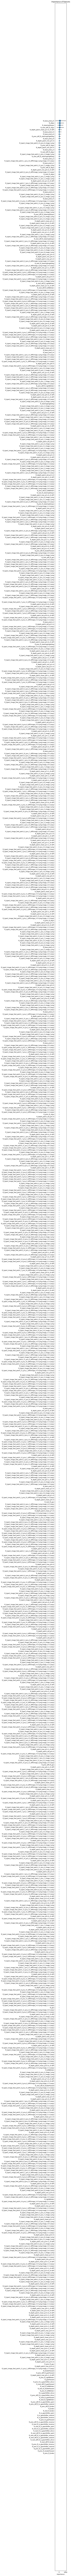

In [18]:
utils.plot_lgb_importance(
    sum([model.models for model in models], []), models[0].feature_names
)

In [19]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

shape: (43_371, 1_124)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ID        ┆ scene_id  ┆ scene_dse ┆ origin_id ┆ … ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_ │
│ ---       ┆ ---       ┆ c         ┆ x         ┆   ┆ ood_z_4   ┆ ood_x_5   ┆ ood_y_5   ┆ cood_z_5 │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ i32       ┆ i64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 00066be8e ┆ 00066be8e ┆ 320       ┆ 0         ┆ … ┆ 0.024672  ┆ 0.083674  ┆ 0.03741   ┆ 0.024108 │
│ 20318869c ┆ 20318869c ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 38c66be46 ┆ 38c66be46 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 663…      ┆ 663…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 00066be8e ┆ 00066be8e ┆ 420       ┆ 1         ┆ … ┆ -0.037533 ┆ -0.089677 ┆ -0.104699 ┆ -0.05046 │
│ 20318869c ┆ 20318869c ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 38c66be46 ┆ 38c66be46 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 663…      ┆ 663…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 00066be8e ┆ 00066be8e ┆ 520       ┆ 2         ┆ … ┆ 0.012231  ┆ 0.015243  ┆ 0.047342  ┆ 0.030025 │
│ 20318869c ┆ 20318869c ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 38c66be46 ┆ 38c66be46 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 663…      ┆ 663…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 000fb056f ┆ 000fb056f ┆ 20        ┆ 4         ┆ … ┆ -0.013157 ┆ 0.105927  ┆ 0.060959  ┆ -0.03074 │
│ 97572d384 ┆ 97572d384 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1        │
│ bae4f5fc1 ┆ bae4f5fc1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ e0f…      ┆ e0f…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 000fb056f ┆ 000fb056f ┆ 120       ┆ 3         ┆ … ┆ -0.019854 ┆ -0.039522 ┆ -0.014148 ┆ -0.03202 │
│ 97572d384 ┆ 97572d384 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ bae4f5fc1 ┆ bae4f5fc1 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ e0f…      ┆ e0f…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ fff88cca5 ┆ fff88cca5 ┆ 120       ┆ 43365     ┆ … ┆ 0.019379  ┆ -0.077388 ┆ 0.086461  ┆ 0.006329 │
│ f8a012427 ┆ f8a012427 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ b96bdde66 ┆ b96bdde66 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 011…      ┆ 011…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ fff88cca5 ┆ fff88cca5 ┆ 220       ┆ 43367     ┆ … ┆ -0.002691 ┆ -0.049667 ┆ 0.054701  ┆ -0.00651 │
│ f8a012427 ┆ f8a012427 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ b96bdde66 ┆ b96bdde66 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 011…      ┆ 011…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ fff88cca5 ┆ fff88cca5 ┆ 320       ┆ 43368     ┆ … ┆ -0.014835 ┆ -0.043888 ┆ 0.020355  ┆ -0.05155 │
│ f8a012427 ┆ f8a012427 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ b96bdde66 ┆ b96bdde66 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 011…      ┆ 011…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ fff88cca5 ┆ fff88cca5 ┆ 420       ┆ 

## 評価

In [20]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = TARGET_COLS

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.06007266786332607,
 'score_pred_tg_cood_y_0': 0.032508721914282876,
 'score_pred_tg_cood_z_0': 0.025763184627377873,
 'score_pred_tg_cood_x_1': 0.12683959495155095,
 'score_pred_tg_cood_y_1': 0.07054463919767207,
 'score_pred_tg_cood_z_1': 0.05295349668724979,
 'score_pred_tg_cood_x_2': 0.21502593323942312,
 'score_pred_tg_cood_y_2': 0.1220157223505498,
 'score_pred_tg_cood_z_2': 0.08061812642286029,
 'score_pred_tg_cood_x_3': 0.3335834217213081,
 'score_pred_tg_cood_y_3': 0.19536558194818474,
 'score_pred_tg_cood_z_3': 0.10886722158742168,
 'score_pred_tg_cood_x_4': 0.48061873398975125,
 'score_pred_tg_cood_y_4': 0.2944136034680384,
 'score_pred_tg_cood_z_4': 0.1376441781735856,
 'score_pred_tg_cood_x_5': 0.6504900284614356,
 'score_pred_tg_cood_y_5': 0.4212204795700852,
 'score_pred_tg_cood_z_5': 0.16716463219588695,
 'avg': 0.19865055379833282}

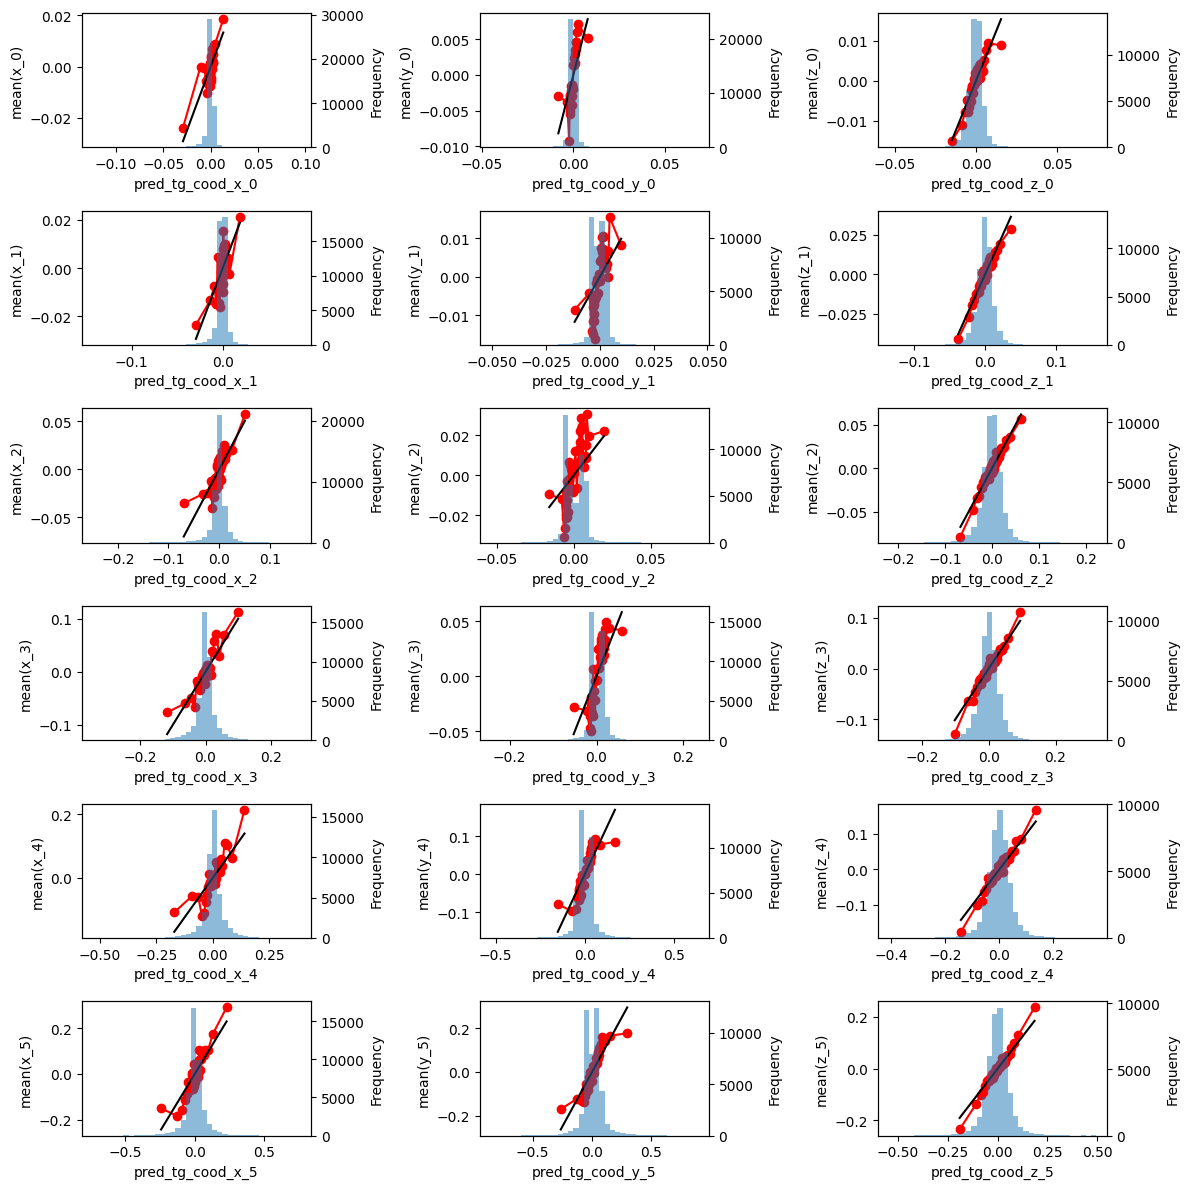

In [21]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

In [22]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    tr_df = add_base_pred_to_target(tr_df, TARGET_COLS)
    tr_df = add_base_pred_to_target(tr_df, pred_cols)

In [23]:
if BASE_PRED_DIR is not None:
    scores = calc_score(tr_df, pred_cols)
    display(scores)

{'score_pred_tg_cood_x_0': 0.06007266786332607,
 'score_pred_tg_cood_y_0': 0.032508721914282876,
 'score_pred_tg_cood_z_0': 0.025763184627377873,
 'score_pred_tg_cood_x_1': 0.12683959495155095,
 'score_pred_tg_cood_y_1': 0.07054463919767207,
 'score_pred_tg_cood_z_1': 0.05295349668724979,
 'score_pred_tg_cood_x_2': 0.21502593323942312,
 'score_pred_tg_cood_y_2': 0.1220157223505498,
 'score_pred_tg_cood_z_2': 0.08061812642286029,
 'score_pred_tg_cood_x_3': 0.3335834217213081,
 'score_pred_tg_cood_y_3': 0.19536558194818474,
 'score_pred_tg_cood_z_3': 0.10886722158742168,
 'score_pred_tg_cood_x_4': 0.4806187339897514,
 'score_pred_tg_cood_y_4': 0.2944136034680384,
 'score_pred_tg_cood_z_4': 0.1376441781735856,
 'score_pred_tg_cood_x_5': 0.6504900284614356,
 'score_pred_tg_cood_y_5': 0.4212204795700852,
 'score_pred_tg_cood_z_5': 0.16716463219588695,
 'avg': 0.19865055379833282}

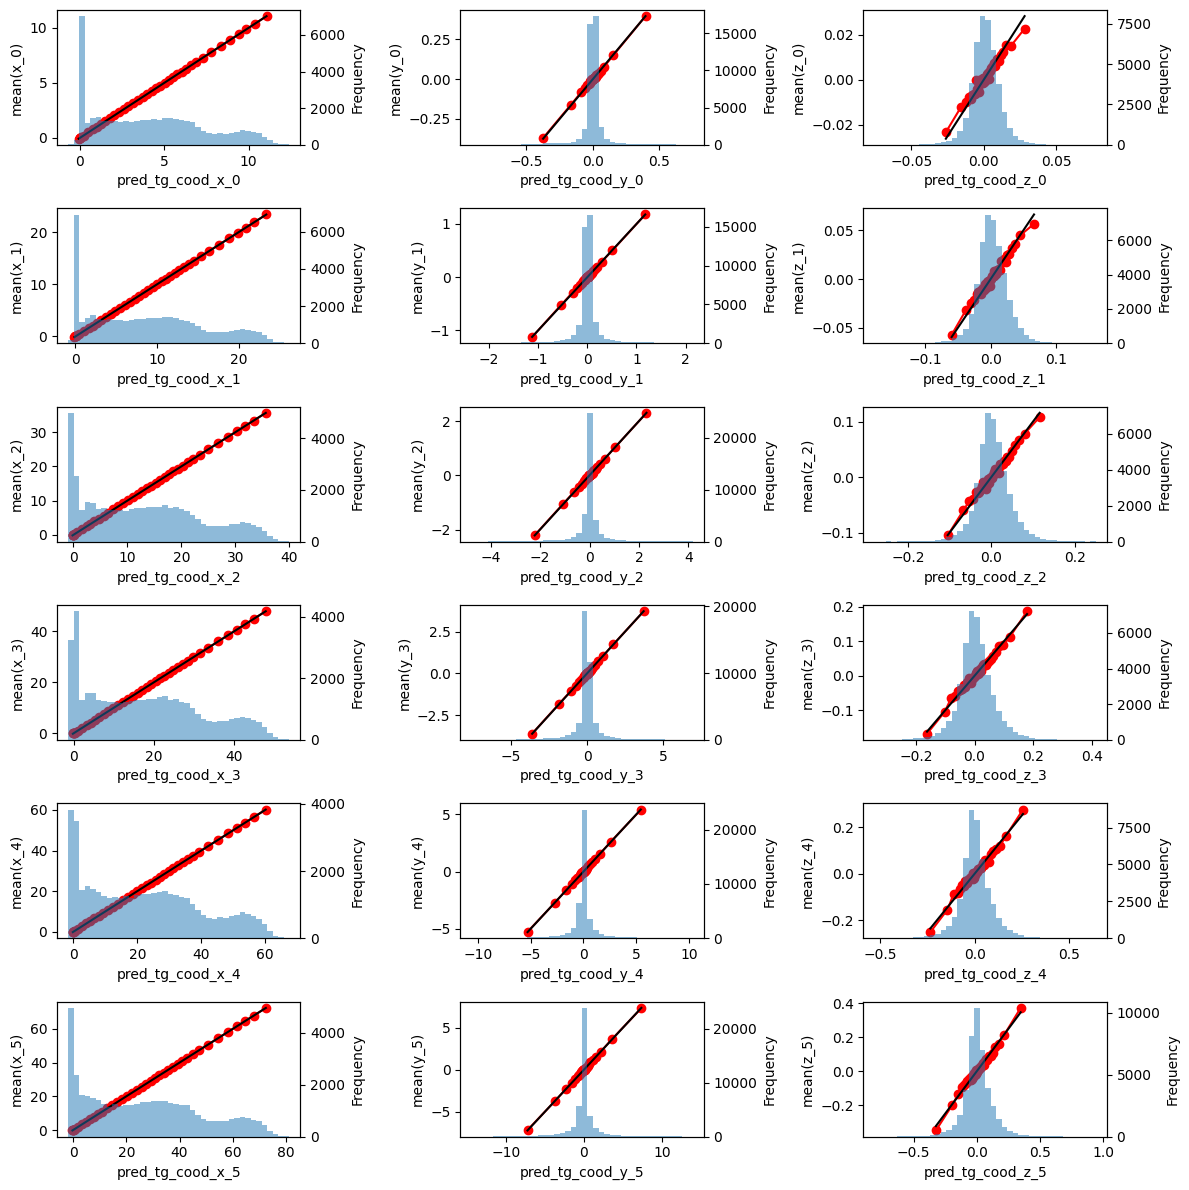

In [24]:
if BASE_PRED_DIR is not None:
    utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## oofを保存

In [25]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = TARGET_COLS

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


# 元の順番に戻して保存
create_submission_csv(tr_df.sort("origin_idx").select(pred_cols), "oof_preds.csv")

Submission file is created: oof_preds.csv


## Submission

In [26]:
preds = utils.predict(
    models,
    ts_df,
    feature.columns,
    pred_cols=pred_cols,
)
pred_cols = preds.columns
ts_df = pl.concat([ts_df, preds], how="horizontal")

preds

shape: (1_727, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ pred_tg_c ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_c ┆ … ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_ │
│ ood_x_0   ┆ ood_y_0   ┆ ood_z_0   ┆ ood_x_1   ┆   ┆ ood_z_4   ┆ ood_x_5   ┆ ood_y_5   ┆ cood_z_5 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.000455  ┆ 0.007175  ┆ -0.002844 ┆ -0.011147 ┆ … ┆ -0.035169 ┆ 0.093042  ┆ 0.00142   ┆ -0.02940 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 3        │
│ 0.006213  ┆ -0.00021  ┆ 0.003245  ┆ 0.003545  ┆ … ┆ 0.017007  ┆ 0.025314  ┆ 0.235192  ┆ 0.034447 │
│ -0.000085 ┆ -0.000058 ┆ 0.004534  ┆ -0.005815 ┆ … ┆ 0.036633  ┆ -0.044351 ┆ -0.030748 ┆ 0.037295 │
│ -0.006498 ┆ -0.003033 ┆ -0.000891 ┆ -0.004515 ┆ … ┆ -0.058097 ┆ 0.054427  ┆ 0.014205  ┆ -0.07450 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ 0.003669  ┆ -0.003129 ┆ 0.002843  ┆ -0.000778 ┆ … ┆ 0.033859  ┆ -0.028705 ┆ -0.031976 ┆ 0.044225 │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ -0.000203 ┆ -0.001841 ┆ 0.0001    ┆ -0.000445 ┆ … ┆ -0.010381 ┆ -0.008988 ┆ -0.021483 ┆ -0.02602 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ -0.006246 ┆ -0.002023 ┆ 0.008381  ┆ -0.002272 ┆ … ┆ -0.140185 ┆ 0.018569  ┆ -0.028133 ┆ -0.20511 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7        │
│ 0.001309  ┆ -0.001098 ┆ 0.003961  ┆ 0.000316  ┆ … ┆ 0.089524  ┆ -0.002547 ┆ 0.050892  ┆ 0.122131 │
│ 0.002676  ┆ 0.001156  ┆ 0.00465   ┆ 0.000586  ┆ … ┆ 0.252791  ┆ -0.015679 ┆ 0.052498  ┆ 0.38275  │
│ -0.000072 ┆ -0.000049 ┆ 0.002125  ┆ 0.000003  ┆ … ┆ 0.05196   ┆ 0.010551  ┆ 0.392883  ┆ 0.088595 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [27]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    ts_df = add_base_pred_to_target(ts_df, pred_cols)
    display(ts_df)

shape: (1_727, 1_088)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ID        ┆ scene_id  ┆ scene_dse ┆ origin_id ┆ … ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_c ┆ pred_tg_ │
│ ---       ┆ ---       ┆ c         ┆ x         ┆   ┆ ood_z_4   ┆ ood_x_5   ┆ ood_y_5   ┆ cood_z_5 │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ i32       ┆ i64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 012baccc1 ┆ 012baccc1 ┆ 120       ┆ 0         ┆ … ┆ -0.059932 ┆ 9.284392  ┆ 0.004095  ┆ -0.06426 │
│ 45d400c89 ┆ 45d400c89 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 6cb82065a ┆ 6cb82065a ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 93d…      ┆ 93d…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 012baccc1 ┆ 012baccc1 ┆ 220       ┆ 1         ┆ … ┆ 0.021089  ┆ 4.297097  ┆ 5.544929  ┆ 0.025993 │
│ 45d400c89 ┆ 45d400c89 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 6cb82065a ┆ 6cb82065a ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 93d…      ┆ 93d…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 012baccc1 ┆ 012baccc1 ┆ 320       ┆ 2         ┆ … ┆ -0.012559 ┆ 9.196936  ┆ -0.047045 ┆ -0.02668 │
│ 45d400c89 ┆ 45d400c89 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ 6cb82065a ┆ 6cb82065a ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 93d…      ┆ 93d…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 012baccc1 ┆ 012baccc1 ┆ 420       ┆ 3         ┆ … ┆ -0.089343 ┆ 3.932163  ┆ 1.651359  ┆ -0.13400 │
│ 45d400c89 ┆ 45d400c89 ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ 6cb82065a ┆ 6cb82065a ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 93d…      ┆ 93d…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 01d738e79 ┆ 01d738e79 ┆ 120       ┆ 4         ┆ … ┆ -0.055486 ┆ 1.487749  ┆ 0.003913  ┆ -0.06050 │
│ 9d260a10f ┆ 9d260a10f ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 6324f7802 ┆ 6324f7802 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3b3…      ┆ 3b3…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ ff4f00a76 ┆ ff4f00a76 ┆ 220       ┆ 1722      ┆ … ┆ -0.02994  ┆ 43.283749 ┆ 1.300537  ┆ -0.06672 │
│ fbf4db0cb ┆ fbf4db0cb ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ 15579c7c6 ┆ 15579c7c6 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 086…      ┆ 086…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ff4f00a76 ┆ ff4f00a76 ┆ 320       ┆ 1723      ┆ … ┆ -0.376141 ┆ 47.381459 ┆ 0.251588  ┆ -0.52666 │
│ fbf4db0cb ┆ fbf4db0cb ┆           ┆           ┆   ┆           ┆           ┆           ┆ 4        │
│ 15579c7c6 ┆ 15579c7c6 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 086…      ┆ 086…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ff4f00a76 ┆ ff4f00a76 ┆ 420       ┆ 1724      ┆ … ┆ 0.206576  ┆ 47.721072 ┆ -0.10779  ┆ 0.287487 │
│ fbf4db0cb ┆ fbf4db0cb ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 15579c7c6 ┆ 15579c7c6 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 086…      ┆ 086…      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ff4f00a76 ┆ ff4f00a76 ┆ 520       ┆ 1

In [28]:
# 元の順番に戻す
ts_df = ts_df.sort("origin_idx")

In [29]:
create_submission_csv(ts_df.select(pred_cols), "submission.csv")

Submission file is created: submission.csv
